In [4]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import random


In [5]:
data = pd.read_csv('Google-Playstore-32K.csv', delimiter=',')
data.dataframeName = 'Google-Playstore-32K.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 32000 rows and 11 columns


In [6]:
data = data.sort_values('Installs', ascending=False)
data = data.drop_duplicates(subset='App Name', keep='first')
maxVal = 10000

#detect null cols and null rate
nulls = [i for i in data.isna().any().index if data.isna().any()[i]==True]
rates = []
counts = []
for i in nulls:    
    rates.append((data[i].isna().sum()/data.shape[0])*100)
    counts.append(data[i].isna().sum())
null_df = pd.DataFrame.from_dict({"Col":nulls,"Count":counts,"Null_Rates":rates})



df_train = data.copy()
#delete Reviews, Latest Version, null values row
for i in ['Reviews','Latest Version']:
    df_train = df_train.drop(df_train.loc[df_train[i].isnull()].index,0)

# PreProcessing Rating Attribute
df_train['Rating'].replace('Lessons', np.nan, inplace=True)
df_train['Rating'].replace('GAME_STRATEGY', np.nan, inplace=True)
df_train['Rating'].replace('NEWS_AND_MAGAZINES', np.nan, inplace=True)
df_train['Rating'] = df_train['Rating'].fillna(df_train['Rating'].median())
# for i in ['Rating']:
#     df_train = df_train.drop(df_train.loc[df_train[i].isnull()].index,0)
df_train['Rating'].astype(float).describe()


# Remove '+' from end of each value
df_train['Installs'] = df_train['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

regex = [r'GAME_[A-Za-z]+.*']
for j in regex:
    df_train['Category_Consolidated'] = df_train['Category'].astype(str).apply(lambda x : re.sub(j, 'GAME', x))
    
regex = [r'[-+|/:/;(_)@\[\]#�,>]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df_train['Latest Version'] = df_train['Latest Version'].astype(str).apply(lambda x : re.sub(j, '0', x))
df_train['Latest Version'].replace('?.?', np.nan, inplace=True)

df_train['Latest Version'] = df_train['Latest Version'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)[:3]).astype(float)
df_train['Latest Version'] = df_train['Latest Version'].fillna(df_train['Latest Version'].median())

df_train['Category_Consolidated'].replace(' Channel 2 News', np.nan, inplace=True)
df_train['Category_Consolidated'].replace(')', np.nan, inplace=True)
df_train = df_train[pd.notnull(df_train['Category_Consolidated'])]

# App values encoding
le = preprocessing.LabelEncoder()
df_train['App Name'] = le.fit_transform(df_train['App Name'])

# Category features encoding
category_list = df_train['Category_Consolidated'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df_train = pd.concat([df_train, pd.get_dummies(df_train['Category_Consolidated'], prefix='cat')], axis=1)

# Encode Content Rating features
le = preprocessing.LabelEncoder()
df_train['Content Rating'] = le.fit_transform(df_train['Content Rating'])


# Price 
df_train['Price'] = df_train['Price'].apply(lambda x : x.strip('$'))
df_train['Price'].replace('Varies with device', np.nan, inplace=True)
df_train['Price'] = df_train['Price'].fillna(df_train['Price'].median())

df_train['Type'] = np.where(df_train['Price'].astype(float) > 0, 'Paid', 'Free')
# Type encoding
df_train['Type'] = pd.get_dummies(df_train['Type'])

df_train['Last Updated'].replace('Everyone 10+', np.nan, inplace=True)
df_train = df_train[pd.notnull(df_train['Last Updated'])]

df_train['Last Updated'] = df_train['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))


regex = [r',']
for j in regex:
    df_train['Size'] = df_train['Size'].astype(str).apply(lambda x : re.sub(j, '', x))
    
# Convert kbytes to Mbytes 
k_indices = df_train['Size'].loc[df_train['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df_train.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df_train.loc[k_indices,'Size'] = converter


df_train['Size'] = df_train['Size'].apply(lambda x: x.strip('M'))
df_train.loc[df_train['Size'] == 'Varies with device', 'Size'] = 0
# df_train[df_train['Size'] == 'Varies with device','Size'] = 0
df_train['Size'] = df_train['Size'].astype(float)

regex = [r'[-+|/:/;(_)@\[\]#�,>]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df_train['Minimum Version'] = df_train['Minimum Version'].astype(str).apply(lambda x : re.sub(j, '0', x))

df_train['Minimum Version'] = df_train['Minimum Version'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)[:3]).astype(float)
df_train['Minimum Version'] = df_train['Minimum Version'].fillna(df_train['Minimum Version'].median())


df_train['Installs'] = df_train['Installs'].astype(int)
df_train['Price'] = df_train['Price'].astype(float)
df_train['Rating'] = df_train['Rating'].astype(float)
df_train['Reviews'] = df_train['Reviews'].astype(int)
# df_train['Last Updated'] = df_train['Last Updated'].astype(float)

df_train['Rating'] =df_train['Rating'].apply(lambda x: round(x, 2))


In [7]:
# Split data into training and testing sets
features = ['App Name', 'Reviews', 'Size',
            'Rating', 'Type', 'Price', 
            'Content Rating', 'Last Updated',
            'Latest Version']

features.extend(category_list)
X = df_train[features][:maxVal]
y = df_train['Installs'][:maxVal]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)



import xgboost as xgb

xgbModel = xgb.XGBClassifier()
xgbModel.fit(X_train, y_train)
accuracy = xgbModel.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 80.2%'

In [12]:
# Split data into training and testing sets
features = ['Reviews', 'Size',
            'Rating', 'Type',
            'Content Rating']

features.extend(category_list)
X = df_train[features][:maxVal]
y = df_train['Installs'][:maxVal]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

xgbModel = xgb.XGBClassifier()
xgbModel.fit(X_train, y_train)
accuracy = xgbModel.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 79.92%'

In [16]:
from sklearn.model_selection import validation_curve

# define range of n_estimators
paramRange = np.linspace(1, 800, 20).astype('int')

# get list of training and validation scores for cv = 5
(train_scores, test_scores) = validation_curve(xgb.XGBClassifier(), X_train,
                                               y_train, param_name='n_estimators',
                                               param_range= paramRange,
                                               scoring='accuracy', n_jobs=-1, verbose=True)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 42.4min finished


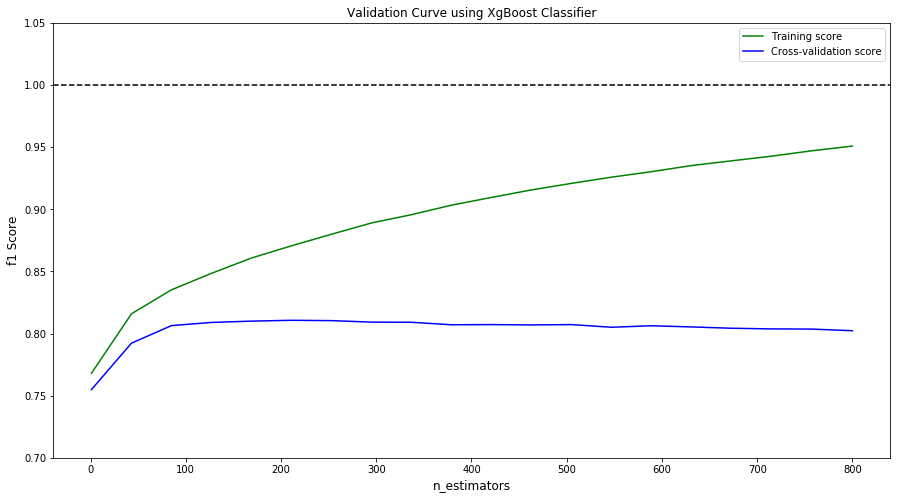

Best cross-validation result (0.81) obtained for 211 trees


In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# Code Referred from https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/
# find mean value of training and validation f1-score
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(paramRange, train_mean, 
         label='Training score',
         color='green')

plt.plot(paramRange, test_mean,
         label='Cross-validation score', 
         color='blue')

plt.axhline(y=1, color='k', ls='dashed')

# plot validation graph
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('f1 Score', fontsize=12)
plt.title('Validation Curve using XgBoost Classifier')
plt.ylim(0.7, 1.05)
plt.legend(loc='best')
plt.show()
i = np.argmax(test_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_mean[i], paramRange[i]))


In [9]:
df_train["Category_Consolidated"]

20981    HEALTH_AND_FITNESS
6747           PRODUCTIVITY
420            PRODUCTIVITY
820                    GAME
304           ENTERTAINMENT
                ...        
11503                  GAME
4854                   GAME
2916                   GAME
25708         ENTERTAINMENT
24784             EDUCATION
Name: Category_Consolidated, Length: 30841, dtype: object